In [1]:
# existing imports
from dataclasses import dataclass
import sys
# from tqdm import tqdm
# third party imports
import scipy.integrate as integrate
import scipy.sparse as sparse
import scipy.linalg
import numpy as np
np.random.seed(101101)
# local imports
sys.path.insert(0,'..')
from src.matrices import get_J_matrix
# display imports
import matplotlib.animation as animation
import matplotlib.pyplot as plt
# from IPython.display import Video

In [2]:
import subprocess

In [3]:
# import tqdm

In [4]:
subprocess.run(["conda", "list"]) 

CompletedProcess(args=['conda', 'list'], returncode=0)

<h1>03-Grid Model</h1>

In [5]:
def get_J_2d_matrix(N,u,w,g=0.0,f=1.0,alpha=1.0,beta=1.0,gamma=1.0):
    dist = src.matrices.RandomMatDist(f=f,u=u)
    inds = np.arange(0,N)
    ssss = dist.sample((N,2))
    mat1 = sparse.csr_matrix((ssss[:,0] * np.exp(g), (inds, (inds+1) % N)), shape=(N, N))
    mat2 = sparse.csr_matrix((ssss[:,1] *np.exp(-g), ((inds+1) % N, inds)), shape=(N, N))
    neig_x = alpha * (mat1 + mat2)
    
    ssss = dist.sample((N,2))
    mat1 = sparse.csr_matrix((ssss[:,0] * np.exp(g), (inds, (inds+1) % N)), shape=(N, N))
    mat2 = sparse.csr_matrix((ssss[:,1] *np.exp(-g), ((inds+1) % N, inds)), shape=(N, N))
    neig_y = alpha * (mat1 + mat2)
    
    identity = sparse.eye(N)
    neig = sparse.kron(neig_x,identity) + sparse.kron(identity,neig_y)

    idnt = gamma * sparse.eye(N**2)

    betp = src.matrices.BetaPrimeDist(beta=beta,w=w)
    inhb = betp.sample((N**2,N**2))
    # inhb[inds,inds] = 0.0

    return neig + idnt - inhb

In [33]:
import src.matrices
parameters = src.matrices.paper_parameters
print(parameters)
N = 20
u, w, alpha, beta, gamma = parameters[2].values()
# matrix_1 = get_J_matrix(N,**parameters[1])
# matrix_2 = get_J_matrix(N,**parameters[1])
# identity = sparse.eye(N)

# matrix_grid = sparse.kron(matrix_1,identity).toarray() + sparse.kron(identity,matrix_2).toarray()
matrix_grid = get_J_2d_matrix(N,**parameters[2])

[{'u': 0.5, 'w': 0.0, 'alpha': 1.0, 'beta': 0.0, 'gamma': 0.0}, {'u': 0.0, 'w': 0.0, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}, {'u': 0.5, 'w': 0.0, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}, {'u': 0.5, 'w': 0.5, 'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0}]


In [34]:
# print(matrix_grid.dtype)
# print(matrix_1.dtype)
# print(matrix_2.dtype)
# plt.imshow(matrix_grid)
# plt.colorbar()
# plt.show()

<h2>Eigenvalues and Eigenvectors</h2>
Looking at the greatest eigenvalues and vectors of the matrix in our differential equation will give us an understanding the stable states of the neural system

In [35]:
temp = np.array(matrix_grid)
print(temp.shape)
lambs, vecs = scipy.linalg.eig(temp)

(400, 400)


In [36]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<h2>Define Differential Equation</h2>
Here we define the differential equation as defined in Tanaka et al. equation (8)
$$
  \tau \frac{dr_i}{dt} = -r_i(t) + f[\sum_j J_{i j} r_j(t) + h_i(t)]
$$
where f is the neurons activation function, and h_i is the ith neurons external input.

Now we can use our class format to have children with different external inputs

<h2>Simulation Time</h2>
Now we are going to simulate the neurons as connected by the above matrix.

In [37]:
tau = 2
tspace = range(100)
r0 = np.zeros((N,N))
r0[N//2:,N//2:] = 2.0
r0 = r0.reshape(N**2)
in_array = np.zeros((len(tspace),*r0.shape))

mu  = 0
vmu = 2
sigma = 5.0
height = 5.0
# sites = slice(0,N//3)
# neurons = NoisyNeuron(matrix,tau,N,mu,sigma)
# neurons = ConstantInput(matrix,tau,N,constant,sites)
neurons = src.matrices.NeuronDiffEq(matrix_grid,tau,N)
results = integrate.odeint(neurons,r0,tspace)

In [38]:
eig_n = 10
ordered_inds = np.argsort(lambs.real)
vecs_sp = vecs[:,ordered_inds[:eig_n]]

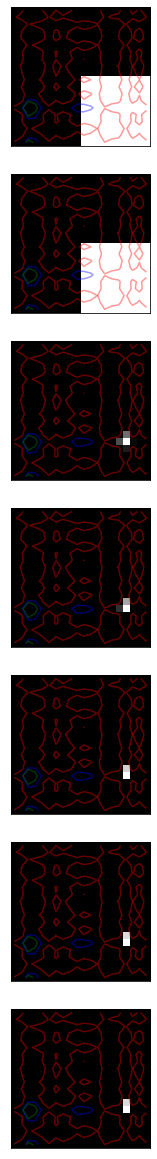

In [39]:
# n_imgs = 3
times_indices = [0,10,20,30,40,50,99]

fig, axs = plt.subplots(len(times_indices),figsize=(6,3*len(times_indices)))
# metrics = np.zeros((len(kernels),*image.shape))
for index,img_i in enumerate(times_indices):

    axs[index].imshow(results[img_i,...].reshape(N,N),cmap='gray')
    axs[index].set_xticks([])
    axs[index].set_yticks([])

n_plots = 3
color_list = ['red','blue','green']
# fig, axs = plt.subplots(n_plots,figsize=(5,5*n_plots))
for index,img_i in enumerate(times_indices):
    for i in range(n_plots):
        axs[index].contour((np.abs(vecs_sp[:,i])**2).reshape(N,N),levels=1,alpha=0.4,colors=color_list[i])
        axs[index].set_xticks([])
        axs[index].set_yticks([])
# plt.savefig('../out/grid_eigs_u{}_w{}_a{}_b{}_g{}.png'.format(u,w,alpha,beta,gamma),dpi=200)
# plt.show()
    
plt.savefig('../out/grid_u{}_w{}_a{}_b{}_g{}.png'.format(u,w,alpha,beta,gamma),dpi=200)
plt.show()

Reorder of eigenvectors by largest values. And selecting some to plot.

In [40]:
len(parameters)

4

In [50]:
parameters = src.matrices.paper_parameters

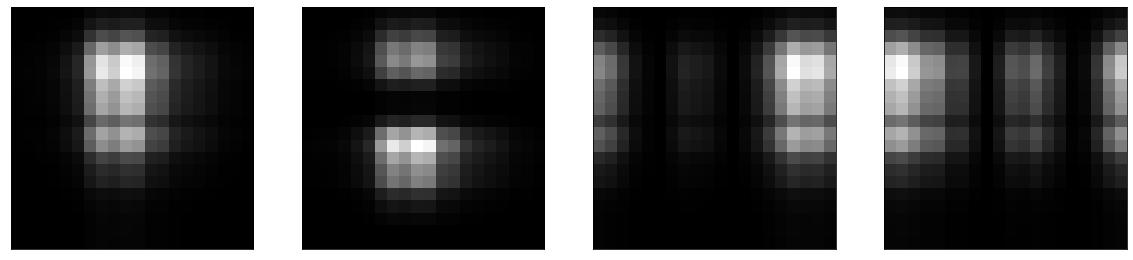

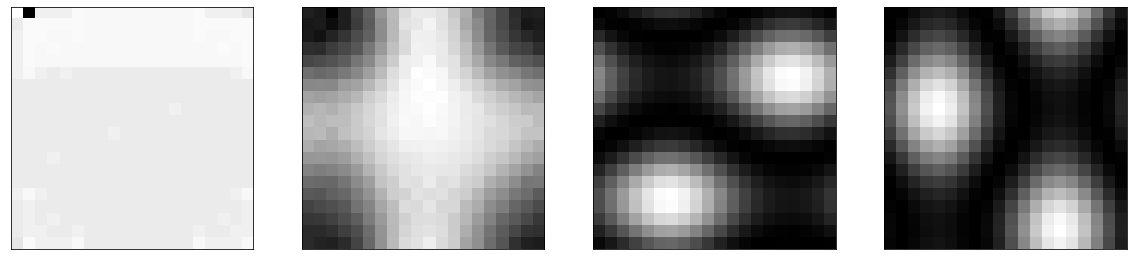

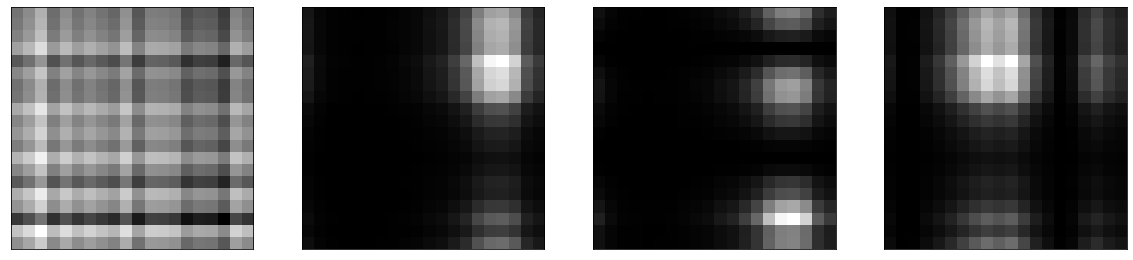

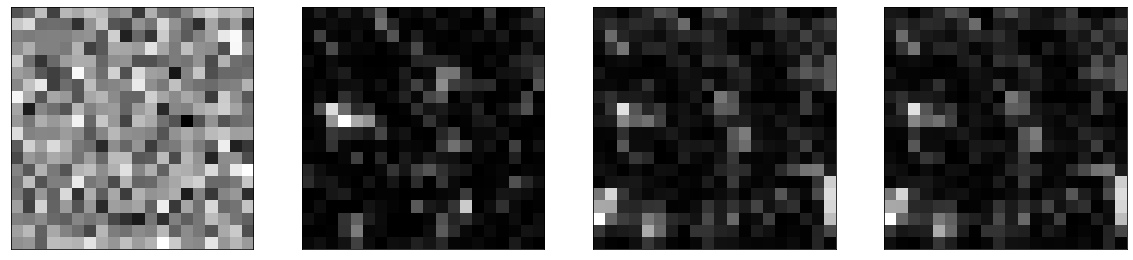

In [51]:
                                                                                               
for i,params in enumerate(parameters):
    n_plots = 4
    fig, axs = plt.subplots(1,n_plots,figsize=(5*n_plots,5),facecolor=(1,1,1))
 
    matrix_grid = get_J_2d_matrix(N,**params)
    temp = np.array(matrix_grid)
    lambs, vecs = scipy.linalg.eig(temp)

    eig_n = 10
    ordered_inds = np.argsort(lambs.real)
    vecs_sp = vecs[:,ordered_inds[:eig_n]]
    
    for j in range(n_plots):
        axs[j].imshow((np.abs(vecs_sp[:,j])**2).reshape(N,N),cmap='gray')
#         axs[j].set_title('param {} eig {}'.format(i,j))
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.savefig('../out/grid_eigs_u{}w{}a{}b{}g{}.png'.format(params['u'],params['w'],params['alpha'],params['beta'],params['gamma']),dpi=200)
    plt.show()

script to write a movie of the neural state evolving over time.

In [15]:
# fig, ax = plt.subplots(figsize=(5, 5))

# n_plots = 3
# color_list = ['red','blue','green']
# for i in range(n_plots):
#     ax.contour((np.abs(vecs_sp[:,i])**2).reshape(N,N),levels=1,alpha=0.4,colors=color_list[i])
#     ax.set_xticks([])
#     ax.set_yticks([])

# line, = ax.imshow(results[0,...].reshape(N,N))
# # ax.axis('equal')

# orders = np.arange(0,len(tspace),dtype=int)
# with tqdm(total=len(tspace)) as pbar:
        
#     def next_image(index):
        
#         line.set_data(results[index,...])
# #         ax.set_title("{}".format(tim_stack[index]))
#         pbar.update(1)
        
#         return line,
            
#     ani = animation.FuncAnimation(
#         fig,
#         next_image,
#         frames=orders,
#         interval=200,
#         repeat=False,
#         repeat_delay=100,
#         blit=True
#     )
# #     plt.show()
#     filename = "out/diffeqJ_u{}_w{}_a{}_b{}_g{}.mp4".format(u,w,alpha,beta,gamma)
#     ani.save(filename)

In [16]:
# Video(filename)

In [17]:
def local_length(states):
    '''
       Return a vector of localization lengths of a set of eigenvectors (states): np.array(n,m)
       where n are the sites and m are the eigenvectors
       Out : np.array(m)
    '''
    return (np.abs(states)**4).sum(axis=0) / (np.abs(states)**2).sum(axis=0)

In [18]:
parameters = {'u'    :0.5
             ,'w'    :0.0
             ,'alpha':1.0
             ,'beta' :1.0
             ,'gamma':1.0}

N = 20
w_space = np.linspace(0,0.3,100)
all_lengths = np.zeros((0,N**2))

for w in w_space:
    parameters['w'] = w
    matrix = get_J_2d_matrix(N=N,**parameters)
    lambs, vecs = scipy.linalg.eig(matrix)
    lengths = local_length(vecs)
    all_lengths = np.concatenate((all_lengths,lengths[None,...]),axis=0)

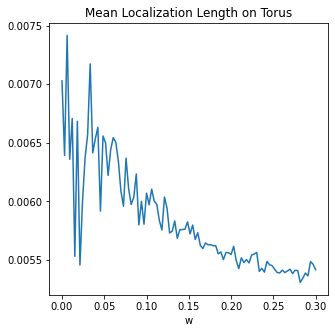

In [26]:
fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(w_space,all_lengths.mean(axis=1))
plt.title('Mean Localization Length on Torus')
plt.xlabel('w')
plt.savefig('../out/mean_locallen_torus.png',dpi=200)
plt.show()

In [27]:
new_parameters = parameters
new_parameters['w'] = 0.02

matrix = get_J_2d_matrix(N=N,**parameters)
lambs, vecs = scipy.linalg.eig(matrix)

eig_n = 10
ordered_inds = np.argsort(lambs.real)
vecs_sp = vecs[:,ordered_inds[:eig_n]]

In [28]:
tau = 2
tspace = range(100)
r0 = np.zeros((N,N))
r0[N//4:3*N//4,N//4:3*N//4] = 2.0
r0 = r0.reshape(N**2)
in_array = np.zeros((len(tspace),*r0.shape))

mu  = 0
vmu = 2
sigma = 5.0
height = 5.0
# sites = slice(0,N//3)
# neurons = NoisyNeuron(matrix,tau,N,mu,sigma)
# neurons = ConstantInput(matrix,tau,N,constant,sites)
neurons = src.matrices.NeuronDiffEq(matrix,tau,N)
results = integrate.odeint(neurons,r0,tspace)

In [29]:
from matplotlib.pyplot import cm

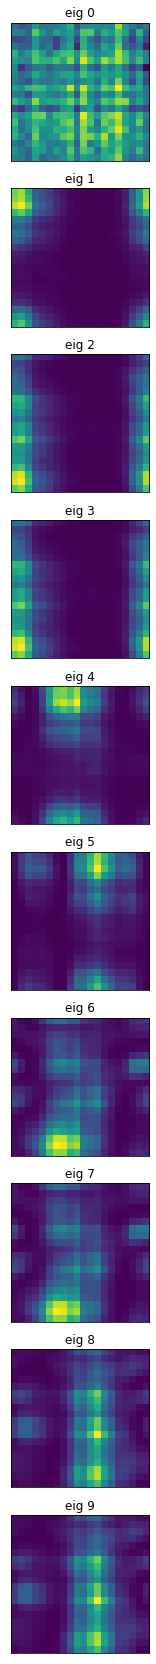

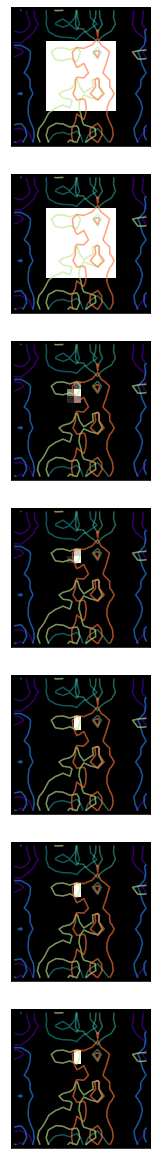

In [31]:
# n_imgs = 3
n_plots = 10
fig, axs = plt.subplots(n_plots,figsize=(3,3*n_plots),edgecolor=(1,1,1))

for j in range(n_plots):
    axs[j].imshow((np.abs(vecs_sp[:,j])**2).reshape(N,N))
    axs[j].set_title('eig {}'.format(j))
    axs[j].set_xticks([])
    axs[j].set_yticks([])
plt.savefig('../out/grid_eigs_u{}_w{}_a{}_b{}_g{}.png'.format(new_parameters['u'],new_parameters['w'],new_parameters['alpha'],new_parameters['beta'],new_parameters['gamma']),dpi=200)
plt.show()

times_indices = [0,10,20,30,40,50,99]

fig, axs = plt.subplots(len(times_indices),figsize=(6,3*len(times_indices)))
# metrics = np.zeros((len(kernels),*image.shape))
for index,img_i in enumerate(times_indices):

    axs[index].imshow(results[img_i,...].reshape(N,N),cmap='gray')
    axs[index].set_xticks([])
    axs[index].set_yticks([])
# color_list = ['red','blue','green','magenta','pink']
color_list = cm.rainbow(np.linspace(0, 1, n_plots))
# fig, axs = plt.subplots(n_plots,figsize=(5,5*n_plots))
for index,img_i in enumerate(times_indices):
    for i in range(1,n_plots):
        axs[index].contour((np.abs(vecs_sp[:,i])**2).reshape(N,N),levels=2,alpha=0.4,colors=color_list[i-1])
        axs[index].set_xticks([])
        axs[index].set_yticks([])
# plt.savefig('../out/grid_eigs_u{}_w{}_a{}_b{}_g{}.png'.format(u,w,alpha,beta,gamma),dpi=200)
# plt.show()
    
plt.savefig('../out/grid_u{}_w{}_a{}_b{}_g{}.png'.format(new_parameters['u'],new_parameters['w'],new_parameters['alpha'],new_parameters['beta'],new_parameters['gamma']),dpi=200)
plt.show()

In [53]:
parameter_list = [{'u'    :0.0
                  ,'w'    :0.0
                  ,'alpha':0.0
                  ,'beta' :0.0
                  ,'gamma':0.3}
                 ,{'u'    :0.0
                  ,'w'    :0.0
                  ,'alpha':1.0
                  ,'beta' :0.0
                  ,'gamma':0.3}
                 ,{'u'    :0.5
                  ,'w'    :0.0
                  ,'alpha':1.0
                  ,'beta' :0.0
                  ,'gamma':0.3}
                 ,{'u'    :0.0
                  ,'w'    :0.0
                  ,'alpha':1.0
                  ,'beta' :0.5
                  ,'gamma':0.3}
                 ,{'u'    :0.5
                  ,'w'    :0.0
                  ,'alpha':1.0
                  ,'beta' :0.5
                  ,'gamma':0.3}
                 ,{'u'    :0.5
                  ,'w'    :0.5
                  ,'alpha':1.0
                  ,'beta' :0.5
                  ,'gamma':0.3}]

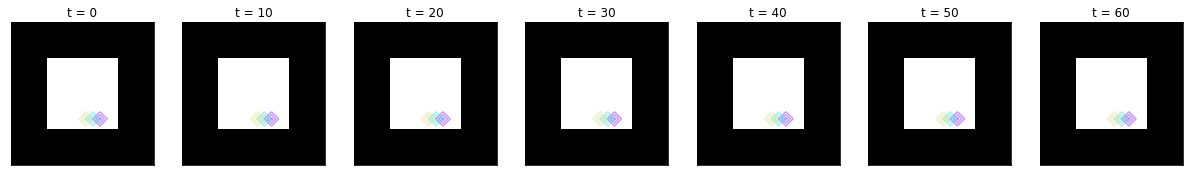

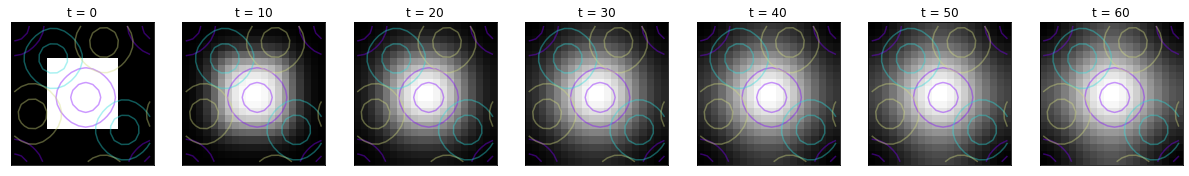

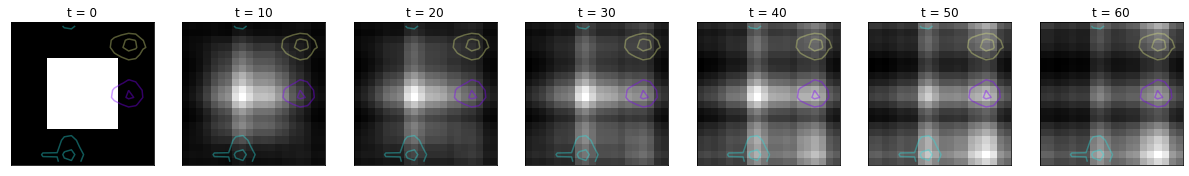

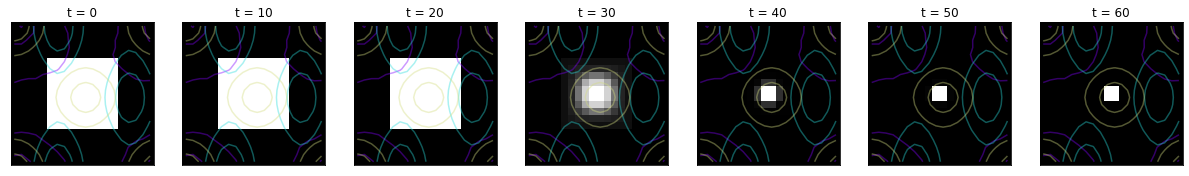

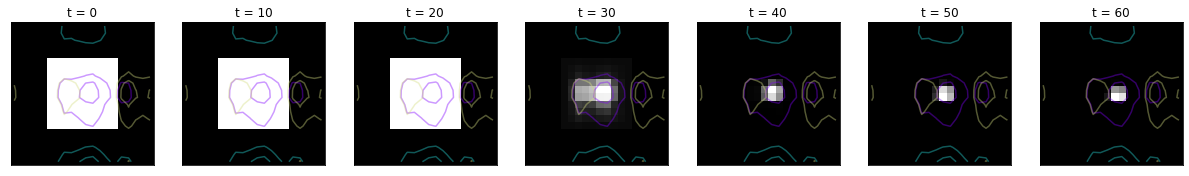

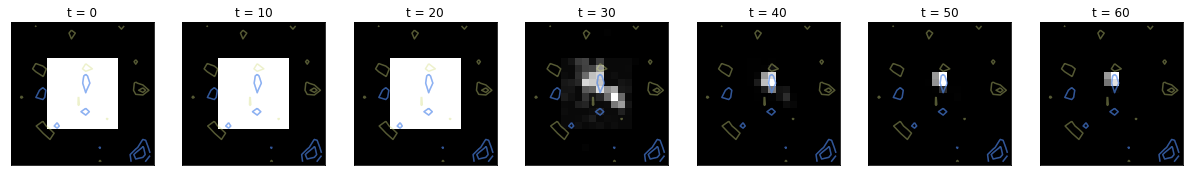

In [64]:
eig_n = 20

tau = 5
tspace = range(100)
r0 = np.zeros((N,N))
r0[N//4:3*N//4,N//4:3*N//4] = 2.0
r0 = r0.reshape(N**2)
in_array = np.zeros((len(tspace),*r0.shape))


for j,p in enumerate(parameter_list):
    fig, axs = plt.subplots(1,len(times_indices),figsize=(3*len(times_indices),3),facecolor=(1,1,1))

    
    matrix = get_J_2d_matrix(N=N,**p)
    lambs, vecs = scipy.linalg.eig(matrix)
    
    ordered_inds = np.argsort(lambs.real)
    vecs_sp = vecs[:,ordered_inds[:eig_n]]
    neurons = src.matrices.NeuronDiffEq(matrix,tau,N)
    results = integrate.odeint(neurons,r0,tspace)

    times_indices = [0,10,20,30,40,50,60]

    # metrics = np.zeros((len(kernels),*image.shape))
    for index,img_i in enumerate(times_indices):

        axs[index].imshow(results[img_i,...].reshape(N,N),cmap='gray')
        axs[index].set_title('t = {}'.format(tspace[img_i]))
        axs[index].set_xticks([])
        axs[index].set_yticks([])
    color_list = cm.rainbow(np.linspace(0, 1, n_plots))
    # fig, axs = plt.subplots(n_plots,figsize=(5,5*n_plots))
    for index,img_i in enumerate(times_indices):
        for i in range(1,n_plots):
            axs[index].contour((np.abs(vecs_sp[:,i])**2).reshape(N,N),levels=2,alpha=0.4,colors=color_list[i-1])
            axs[index].set_xticks([])
            axs[index].set_yticks([])
    # plt.savefig('../out/grid_eigs_u{}_w{}_a{}_b{}_g{}.png'.format(u,w,alpha,beta,gamma),dpi=200)
    # plt.show()

    plt.savefig('../out/grid_evolution_6ps_{}'.format(j),dpi=200)
    plt.show()